## Saving a Cats v Dogs Model

This is a minimal example showing how to train a fastai model on Kaggle, and save it so you can use it in your app.

In [2]:
# Make sure we've got the latest version of fastai:
!pip install -Uqq fastai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.3 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.3 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.3 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.3 requires wrapt~=1.12.1, but you have wrapt 1.14.0 which is incompatible.
tensorflow-transform 1.7.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow-transform 1.7.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.3 which is incompatible.
tensorflow-serving-api 2.8.0 requires tensorflow<3,>=2.8.0, but you have tensorflow 2.6.3 which i

First, import all the stuff we need from fastai:

In [3]:
from fastai.vision.all import *

Download and decompress our dataset, which is pictures of dogs and cats:

In [4]:
path = untar_data(URLs.PETS)/'images'

We need a way to label our images as dogs or cats. In this dataset, pictures of cats are given a filename that starts with a capital letter:

In [6]:
def is_cat(x): return x[0].isupper() 

Now we can create our `DataLoaders`:

In [7]:
dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat,
    item_tfms=Resize(192))

... and train our model, a resnet18 (to keep it small and fast):

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.174433,0.059776,0.019621,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.051591,0.056535,0.017591,00:32
1,0.043828,0.037467,0.010825,00:32
2,0.018390,0.029024,0.008119,00:32


Now we can export our trained `Learner`. This contains all the information needed to run the model:

In [9]:
learn.export('model.pkl')

Finally, open the Kaggle sidebar on the right if it's not already, and find the section marked "Output". Open the `/kaggle/working` folder, and you'll see `model.pkl`. Click on it, then click on the menu on the right that appears, and choose "Download". After a few seconds, your model will be downloaded to your computer, where you can then create your app that uses the model.

# Allright, lets build my own model!

In [16]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")
    
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

!pip install voila
!jupyter serverextension enable --sys-prefix voila

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2' fastbook # Remember to set environment to always use latest environment. Else it won't work

In [25]:
from duckduckgo_search import DDGS #DuckDuckGo has changed the api so we need to update 
from fastcore.all import *
from fastdownload import download_url
import time, json
from fastai.vision.all import *
from fastbook import *
from fastai.vision.widgets import *
import fastai.data.transforms as fdt


In [4]:
# Create functions

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')


In [48]:
# Let's get some data
searches = 'rabbits', "bears", "dogs"
path = Path("rabbit_bears_dogs_classifier")


for o in searches:
    print(o)
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=200, dest=path/o)

rabbits
bears
dogs


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [49]:
# Some links might be broken, so lets not include those
failed = verify_images(fdt.get_image_files(path))
failed.map(Path.unlink) # Using map removes them from the directory
print(f'Percentage of failed: {len(failed) / len(fdt.get_image_files(path))}')


Percentage of failed: 0.011535048802129548


To turn our downloaded data into a DataLoaders object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

In [50]:
# Lets get the data
rabbits = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

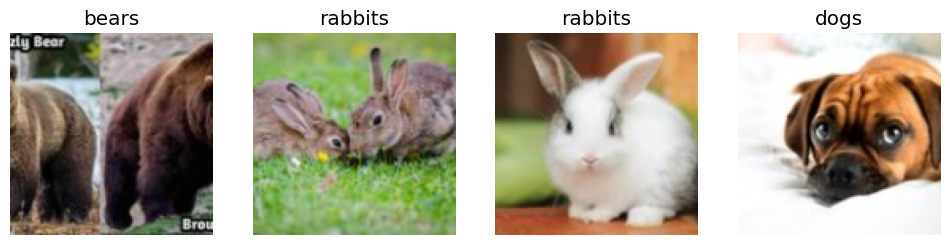

In [51]:
# Having the dataloader object (x,y + where files are + splitting into train/val + how to get y + the size of the images) lets use it
dls = rabbits.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

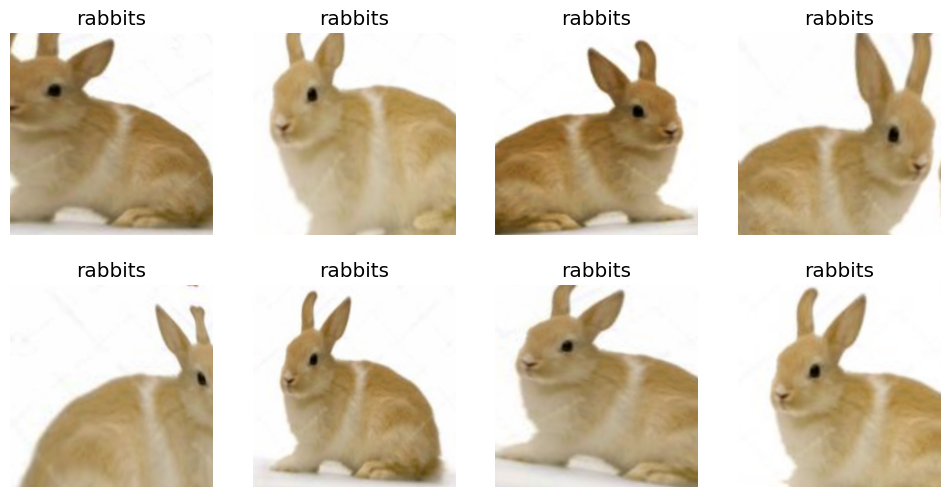

In [52]:
# Lets try to do some data augmentation = get some more data
rabbits = rabbits.new(
    item_tfms=RandomResizedCrop(224, min_scale=.5),
    batch_tfms=aug_transforms())
dls = rabbits.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [53]:
# Lets try and create the model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.707999,0.143643,0.035556,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.141047,0.062459,0.013333,00:03
1,0.116332,0.012068,0.004444,00:03
2,0.086765,0.012230,0.004444,00:02
3,0.071060,0.010643,0.004444,00:02


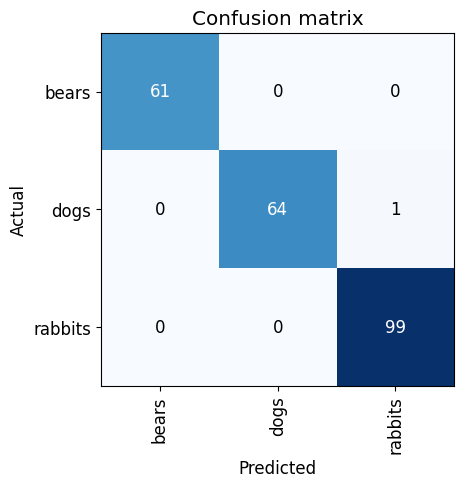

In [54]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

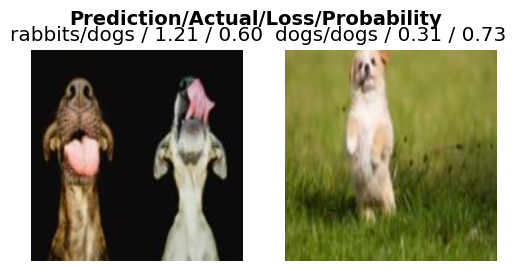

In [55]:
# lets view the worst cases
interp.plot_top_losses(2, nrows=1)

In [56]:
# The first one is not correctly labeled so lets delete it
cleaner = ImageClassifierCleaner(learn)
cleaner

In [57]:
# Made an error the last time, so not running it.

#for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Lets try and export the model

In [58]:
learn.export() # create a .pkl file

In [61]:
path = Path()
path.ls(file_exts='.pkl') # use ls to add fastai to python path class

(#1) [Path('export.pkl')]

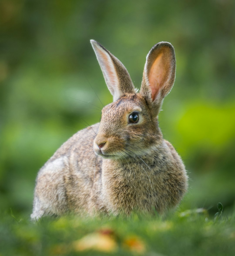

In [64]:
download_url(search_images("rabbit photos", max_images=1)[0], "rabbit_test.jpg", show_progress=False)
Image.open('rabbit_test.jpg').to_thumb(256,256)

In [80]:
# mimic load and inference
learn_inf = load_learner(path/'export.pkl')
yhat = learn_inf.predict('rabbit_test.jpg')
print(f"Scores: {yhat}")
print(f"Order: {learn_inf.dls.vocab}") # alphabetic order
print(f"Probability it is a rabbit: {yhat[2][2]}")

Scores: ('rabbits', tensor(2), tensor([3.9881e-08, 1.3933e-05, 9.9999e-01]))
Order: ['bears', 'dogs', 'rabbits']
Probability it is a rabbit: 0.9999860525131226


# Lets create the app

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
#hide_output
VBox([widgets.Label('Select your rabbit!'), 
      btn_upload, btn_run, out_pl, lbl_pred])